In [26]:
import os.path as op
import os
import numpy as np
import pandas as pd
from bauer.models import MagnitudeComparisonRegressionModel, FlexibleNoiseComparisonRegressionModel

from utils import get_data

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_magjudge')

if not op.exists(target_folder):
    os.makedirs(target_folder)

df = get_data(bids_folder)
df.reset_index('run', inplace=True) 


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [5]:
sub = 1
data = df.xs(sub,0,'subject')

In [49]:
model = MagnitudeComparisonRegressionModel(data, 
                            regressors = {},
                            fit_prior=True,
                            fit_seperate_evidence_sd = True, 
                            memory_model='shared_perceptual_noise',
                            )
model_label = '5'

In [50]:
df = df.sort_index()

In [52]:
def fit_model_individual(d, model=model):
    model.build_estimation_model(d, hierarchical=False)
    return model.fit_map()

maps = df.loc[:2].groupby(['subject', 'group']).apply(fit_model_individual)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'perceptual_noise_sd': array([0.]), 'memory_noise_sd': array([0.]), 'prior_mu': array([12.30833333]), 'prior_sd': array([0.])}

Logp initial evaluation results:
{'perceptual_noise_sd': -0.92, 'memory_noise_sd': -0.92, 'prior_mu': -inf, 'prior_sd': -0.92, 'll_bernoulli': -267.96}
You can call `model.debug()` for more details.

In [41]:
from bauer.utils.bayes import softplus

maps = softplus(maps)

In [48]:
df_maps = maps.droplevel(-1, axis=1).droplevel(-1, axis=0)
df_maps.to_csv(op.join(source_folder, f'bauer-{model_label}_sds-maps_unbiased.csv'))


In [43]:
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'
vs_wm = pd.read_csv(op.join(source_folder, 'visio-spatial-WM_CBTtask-params.csv'))
vs_wm.set_index('subject', inplace=True)

panamath_scores = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/panamath_AllRunsSummary.csv')
df_pana = panamath_scores.rename(mapper={'Subject ID': 'subject'}, axis=1).set_index('subject')[['Number of Trials','Weber Fraction', 'Percent Correct', 'Number of Non-RT-Outlier Trials']]
df_pana = df_pana.rename(mapper={'Weber Fraction': 'weber_frac'}, axis=1).drop(999, axis=0).sort_index()


In [54]:
df_comb =df_maps.join(vs_wm).join(df_pana['weber_frac'])
df_comb.head()

df_comb = df_comb.drop(46)

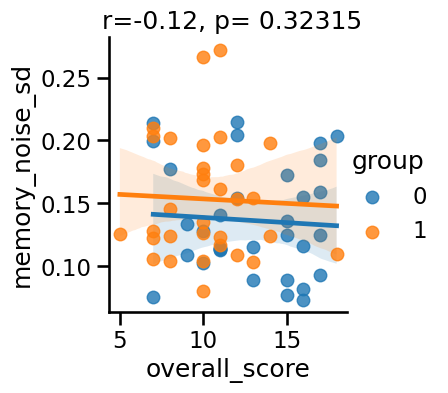

In [55]:
import seaborn as sns
import pingouin
sns.set_context('talk')

y_var = 'memory_noise_sd' #'skill_score' # '4c' # 4b' #
x_var = 'overall_score'#'gamma_nonsymbolic' # 'conf_mean'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb.reset_index(), hue='group',height=4) #, hue='group'
fig.set(title=f' r={r_}, p= {p}' )

[Text(0.5, 1.0, 'p=0.137')]

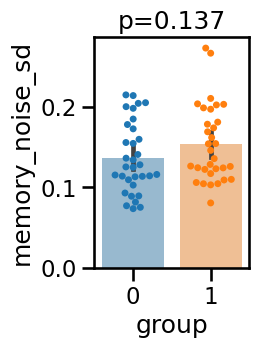

In [57]:
import matplotlib.pyplot as plt

y_var = 'memory_noise_sd' 

fig, ax = plt.subplots(figsize=(2,3))
sns.barplot(ax=ax,data=df_comb.reset_index(), x='group', y=y_var, hue='group',alpha=0.5,legend=False)
sns.swarmplot(ax=ax, data=df_comb.reset_index(), x='group', y=y_var,  hue='group',size=5,legend=False)

an = pingouin.anova(data=df_comb.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)
ax.set(title=f'p={p_val}')